## **Introduction**

In this jupyter notebook, we build LSTM models for taxi trips from the period 2015 to 2016.

## **Setting up the environment**

In [ ]:
!pip install holidays

!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=c5aa72f1a2502e8a110f1f3c4de1468087fdf725c64cc45f2e3360b948a0573e
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from numpy import array
import datetime
from datetime import date
from datetime import timedelta
import os
import holidays

from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers 
import keras.backend as K

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#from google.colab import drive
#drive.mount('/content/gdrive')

Using TensorFlow backend.


time: 2.16 s


## **Common parameters and functions to all models**

In [ ]:
#initial date for training Jan 1st 2015 Midnight
initial_date = datetime.datetime(2015, 1, 1, 0, 0)

#validation hour range
validation_range = 24*7*8

#test hour range
test_range = 24*7*3

def convertIndexToDate(indexValue):
  return initial_date + timedelta(hours=indexValue)

def convertDatetoHourIndex(taxiTripTimeStamp, yeartaxitrip):
  taxitripdate = datetime.datetime(year=yeartaxitrip, month=taxiTripTimeStamp[0], day=taxiTripTimeStamp[1], hour=taxiTripTimeStamp[2])
  diff = taxitripdate - initial_date
  return int(diff.total_seconds() / 3600.0)

def returnValidTestIndexes(endTrainingIndex):
  startValidationIndex = endTrainingIndex
  endValidationIndex = endTrainingIndex + validation_range
  startTestIndex = endValidationIndex
  return [startValidationIndex, startTestIndex]


time: 8.85 ms


In [ ]:
#CAN BE MODIFIED!!!!!!!
end_training_index = convertDatetoHourIndex([9, 7, 8], 2016)
test_StartDate = "2016-09-07 08:00"
test_start_date_title = "2016_09_07_800"


#loading the dataframe
taxitrips_df = pd.read_csv("/content/two_years_2015_2016_dataframe.csv")

#list of regions by new/end flows
regions_to_loop_newflow = ['26_new', '53_new', '60_new', '62_new', '66_new', '68_new', '72_new', '73_new', '75_new', '76_new', '77_new', '78_new', '82_new', '83_new', '88_new', '125_new']
regions_to_loop_endflow = ['26_end', '53_end', '60_end', '62_end', '66_end', '68_end', '72_end', '73_end', '75_end', '76_end', '77_end', '78_end', '82_end', '83_end', '88_end', '125_end']

#setting training data
forecastHourRange = test_range
start_training_index = 0


#NO MODIFICATION NEEDED: path to folder containing the forecasts
base_results_csv_path_LSTM_twovariate = "/content/gdrive/My Drive/urban-computing-project/LSTM_twovariate_results/"
base_results_csv_path_LSTM_multivariate = "/content/gdrive/My Drive/urban-computing-project/LSTM_multivariate_results/"

statistical_method_twovariate = "LSTM_twovariate"
statistical_method_multivariate = "LSTM_twovariate"

#federal holidays
us_holidays = holidays.UnitedStates()

time: 136 ms


**RMSE functions**

In [ ]:
def returnRMSEofTensors(yforecast, y):
  yforecast[yforecast < 0] = 0
  ydifference = (yforecast - y)**2
  rmse = (ydifference.sum()/(y.shape[0]*y.shape[1]))**0.5
  return int(rmse)

def returnRMSEofTensorsForPeriodForecastArray(yforecast, y, periodForecastArray):
  rmseArray = []
  for periodForecast in periodForecastArray:
    rmse = returnRMSEofTensors(yforecast[:periodForecast], y[:periodForecast])
    rmseArray.append(rmse)
  return rmseArray

def returnAverageValueTaxiFlows(y):
  averageflows = y.sum() / (y.shape[0]*y.shape[1])
  return int(averageflows)

def returnAverageTaxiFlowsArray(y, periodForecastArray):
  averageTaxiFlowsArray = []
  for periodForecast in periodForecastArray:
    averageTaxiFlowsArray.append(returnAverageValueTaxiFlows(y[:periodForecast]))
  return averageTaxiFlowsArray

def returnRelativeRMSEtoAverage(rmseArray, averageTaxiTripsArray):
  relativeRMSEtoAverageArray = []
  m = len(rmseArray)
  k = 0
  while k < m:
    if averageTaxiTripsArray[k] > 0:
      relativeRMSEtoAverageArray.append(int(100*rmseArray[k]/averageTaxiTripsArray[k]))
    else:
      relativeRMSEtoAverageArray.append(0)
    k = k + 1
  return relativeRMSEtoAverageArray


time: 17.2 ms


**File management functions**

In [ ]:
def returnBaseNameOfFileFullPath(resultDatasetPath):
    name = resultDatasetPath.split('/')
    baseName = name[len(name)-1]
    name = baseName.split('.')
    return name[0]

def returnForecastsInDataframe(yForecastTest, yTest, regionsTitleArray, initialTestingDate):
    n = yTest.shape[0]
    date_df = pd.date_range(pd.Timestamp(initialTestingDate), periods=n, freq='h')
    
    region_forecasts_title_array = []
    region_test_title_array = []
    for regionIDtitle in regionsTitleArray:
      region_forecasts_title_array.append(regionIDtitle + "_forecast")
      region_test_title_array.append(regionIDtitle + "_test")
    
    columns = region_forecasts_title_array + region_test_title_array
    y_data = np.concatenate( (yForecastTest, yTest) ,axis=1)
    data = np.array(y_data)
    df = pd.DataFrame(data=data, columns=columns)

    df["timestamp"] = date_df

    return df

def saveforecastsintoCSV(yForecastTest, yTest, regionsTitleArray, initialTestingDate, resultsCSVFilePath):
  df = returnForecastsInDataframe(yForecastTest, yTest, regionsTitleArray, initialTestingDate)
  df.to_csv(resultsCSVFilePath)

time: 21.1 ms


**LSTM model**

In [ ]:
def returnLSTMModel(sequenceLength, xtrain, ytrain, batchSize, nunits, initialLearningRate):
  generator = TimeseriesGenerator(xtrain, ytrain, length=sequenceLength, batch_size=batchSize)
  lstm_model = Sequential()
  lstm_model.add(LSTM(nunits, activation='relu', input_shape=(sequenceLength, xtrain.shape[1])))
  lstm_model.add(Dense(ytrain.shape[1]))
  adamOpti = optimizers.Adam(learning_rate=initialLearningRate)
  lstm_model.compile(optimizer=adamOpti, loss='mse') 

  return [lstm_model, generator]

def returnLSTMModelSaved(FullpathToSavedModel):
  return keras.models.load_model(FullpathToSavedModel)

def returnLSTMForecast(lstm_model, sequenceLength, forecastPeriodRange, xtrain, featuresArray):
  lstm_predictions_scaled = list()

  batch = xtrain[-sequenceLength:]

  current_batch = batch.reshape((-1, sequenceLength, xtrain.shape[1]))

  j = 0
  for i in range(forecastPeriodRange):   
      lstm_pred = lstm_model.predict(current_batch)[0]

      elem_array = []
      for prediction in lstm_pred:
        elem_array.append(prediction)

      for feature in featuresArray[j]:
        elem_array.append(feature)

      elem = np.array(elem_array)
      elem = elem.reshape((1, xtrain.shape[1]))

      lstm_predictions_scaled.append(lstm_pred) 

      current_batch = np.append(current_batch[0] , elem, axis = 0)
      current_batch = current_batch[1:]
      current_batch = current_batch.reshape((-1, sequenceLength, xtrain.shape[1]))
      j = j + 1

  return lstm_predictions_scaled 

time: 47.6 ms


In [ ]:
def printModelTrainingValidationLoss(modelHistory):
  # summarize history for loss
  plt.plot(modelHistory.history['loss'][1:])
  plt.plot(modelHistory.history['val_loss'][1:])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

time: 2.86 ms


**Simulation function**

In [ ]:
def runLSTMSimulationWithValidationMonitoring(resultsCSVFilePath, regionsTitleArray, dataSets, featuresSets, initialTestingDate, endingIndexForTraining, periodForecastArray,sequenceLength, batchSize, nunits, lstmModelName, numberEpochsArray,learningRateArray, verbose, saveModelToPath = "No"):

  startValidationIndex, startTestIndex = returnValidTestIndexes(endingIndexForTraining)

  print("startValidationIndex, startTestIndex", startValidationIndex, startTestIndex)

  #getting the data
  y_ = dataSets.copy()
  y_train = y_[:startValidationIndex].copy()
  y_validation = y_[startValidationIndex:startTestIndex].copy()
  y_test = y_[startTestIndex:].copy()
  
  #features
  features_train = featuresSets[:startValidationIndex]
  features_validation = featuresSets[startValidationIndex:startTestIndex]
  features_test = featuresSets[startTestIndex:]
  
  #scaling the target data
  scaler = MinMaxScaler()

  #scaling the data based on data inside the train dataset
  scaler.fit(y_train)
  scaled_train_data = scaler.transform(y_train)

  #the input of the test is the validation set
  scaled_test_data = scaler.transform(y_validation)

  #combining the data
  scaled_train_data_input = np.concatenate((scaled_train_data, features_train), axis=1)

  #the input for the test is the data of the validation
  scaled_test_data_input = np.concatenate((scaled_test_data, features_validation), axis=1)

  #get the lstm model
  lstmModel, generator = returnLSTMModel(sequenceLength, scaled_train_data_input, scaled_train_data, batchSize, nunits, learningRateArray[0])

  #creating validation set to select number of epochs
  scaled_validation_data_input_length = scaled_test_data_input.shape[0]
  validation_last_index = scaled_validation_data_input_length - sequenceLength
  validation_generator = TimeseriesGenerator(scaled_test_data_input[:validation_last_index], scaled_test_data[:validation_last_index], length=sequenceLength, batch_size=batchSize)

  print()
  print("Model training information")
  print("Initial training date :", convertIndexToDate(0))
  print("End training date :", convertIndexToDate(startValidationIndex-1))
  print("Start Validation date :", convertIndexToDate(startValidationIndex))
  print("End validation date :", convertIndexToDate(startValidationIndex + validation_last_index))
  print("Start test date :", convertIndexToDate(startTestIndex))
  print("End test date :", convertIndexToDate(startTestIndex + y_test.shape[0]-1))
  print("Start test input date :", convertIndexToDate(startTestIndex-sequenceLength))
  print("Sequence length :", sequenceLength)


  print()
  print("First round of training [epochs, learning rate]", numberEpochsArray[0], learningRateArray[0])
  print()

  #training: 1st training with first learning rate and number of epochs
  history_1 = lstmModel.fit_generator(generator, epochs=numberEpochsArray[0], validation_data=validation_generator, verbose=verbose)

  print()
  print("Second round of training [epochs, learning rate]", numberEpochsArray[1], learningRateArray[1])
  print()

  #training: 2st training with second learning rate and number of epochs
  K.set_value(lstmModel.optimizer.lr, learningRateArray[1])
  history_2 = lstmModel.fit_generator(generator, epochs=numberEpochsArray[1], validation_data=validation_generator, verbose=verbose)
  

  #print training and validation losses
  printModelTrainingValidationLoss(history_1)
  print()
  printModelTrainingValidationLoss(history_2)

  #forecasts on validation set
  #returnLSTMForecast(lstm_model, sequenceLength, forecastPeriodRange, xtrain, featuresArray)
  period_to_forecast = y_validation.shape[0]
  lstm_predictions_scaled = returnLSTMForecast(lstmModel, sequenceLength, period_to_forecast, scaled_train_data_input, features_validation)
  lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
  y_forecast_validation = lstm_predictions.copy()

  #forecast on validation period, computing RMSE for validation set
  rmse_validation_array = returnRMSEofTensorsForPeriodForecastArray(y_forecast_validation, y_validation, periodForecastArray[0])
  average_taxi_trips_validation_array = returnAverageTaxiFlowsArray(y_validation, periodForecastArray[0])
  rmse_to_average_taxi_trips_validation_array = returnRelativeRMSEtoAverage(rmse_validation_array, average_taxi_trips_validation_array)
  print("Validation set results")
  print("Region IDs :", regionsTitleArray)
  print("Forecast time range (h) :", periodForecastArray[0])
  print("RMSE :", rmse_validation_array)
  print("Average Taxi flows :", average_taxi_trips_validation_array)
  print("RMSE to average % :", rmse_to_average_taxi_trips_validation_array)

  #forecast on test period, computing RMSE for test set
  period_to_forecast = y_test.shape[0]
  lstm_predictions_scaled = returnLSTMForecast(lstmModel, sequenceLength, period_to_forecast, scaled_test_data_input[validation_last_index:], features_test)
  lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
  y_forecast_test = lstm_predictions.copy()

  rmse_test_array = returnRMSEofTensorsForPeriodForecastArray(y_forecast_test, y_test, periodForecastArray[1])
  average_taxi_trips_test_array = returnAverageTaxiFlowsArray(y_test, periodForecastArray[1])
  rmse_to_average_taxi_trips_test_array = returnRelativeRMSEtoAverage(rmse_test_array, average_taxi_trips_test_array)
  print()
  print("Test set results")
  print("Forecast time range (h) :", periodForecastArray[1])
  print("RMSE :", rmse_test_array)
  print("Average Taxi flows :", average_taxi_trips_test_array)
  print("RMSE to average % :", rmse_to_average_taxi_trips_test_array)

  print()
  
  #save results in CSV
  #to save: regionsTitleArray, y_forecast_test, y_test, initialTestingDate, resultsCSVFilePath 
  saveforecastsintoCSV(y_forecast_test, y_test, regionsTitleArray, initialTestingDate, resultsCSVFilePath)

  #save model 
  if len(saveModelToPath) > 5:
    lstmModel.save(saveModelToPath)


time: 144 ms


In [ ]:
def runLSTMSimulation(resultsCSVFilePath, regionsTitleArray, dataSets, featuresSets, initialTestingDate, endingIndexForTraining, periodForecastArray,sequenceLength, batchSize, nunits, lstmModelName, numberEpochsArray,learningRateArray, verbose, saveModelToPath = "No"):

  startValidationIndex, startTestIndex = returnValidTestIndexes(endingIndexForTraining)

  #getting the data
  y_ = dataSets.copy()
  y_train = y_[:startValidationIndex].copy()
  y_validation = y_[startValidationIndex:startTestIndex].copy()
  y_test = y_[startTestIndex:].copy()
  
  #features
  features_train = featuresSets[:startValidationIndex]
  features_validation = featuresSets[startValidationIndex:startTestIndex]
  features_test = featuresSets[startTestIndex:]
  
  #scaling the target data
  scaler = MinMaxScaler()

  #scaling the data based on data inside the train dataset
  scaler.fit(y_train)
  scaled_train_data = scaler.transform(y_train)

  #the input of the test is the validation set
  scaled_test_data = scaler.transform(y_validation)

  #combining the data
  scaled_train_data_input = np.concatenate((scaled_train_data, features_train), axis=1)

  #the input for the test is the data of the validation
  scaled_test_data_input = np.concatenate((scaled_test_data, features_validation), axis=1)

  #get the lstm model
  lstmModel, generator = returnLSTMModel(sequenceLength, scaled_train_data_input, scaled_train_data, batchSize, nunits, learningRateArray[0])

  #training: 1st training with first learning rate and number of epochs
  lstmModel.fit_generator(generator, epochs=numberEpochsArray[0], verbose=verbose)

  #training: 2st training with second learning rate and number of epochs
  K.set_value(lstmModel.optimizer.lr, learningRateArray[1])
  lstmModel.fit_generator(generator, epochs=numberEpochsArray[1], verbose=verbose)
  
  #forecasts on validation set
  #returnLSTMForecast(lstm_model, sequenceLength, forecastPeriodRange, xtrain, featuresArray)
  period_to_forecast = y_validation.shape[0]
  lstm_predictions_scaled = returnLSTMForecast(lstmModel, sequenceLength, period_to_forecast, scaled_train_data_input, features_validation)
  lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
  y_forecast_validation = lstm_predictions.copy()

  #forecast on validation period, computing RMSE for validation set
  rmse_validation_array = returnRMSEofTensorsForPeriodForecastArray(y_forecast_validation, y_validation, periodForecastArray[0])
  average_taxi_trips_validation_array = returnAverageTaxiFlowsArray(y_validation, periodForecastArray[0])
  rmse_to_average_taxi_trips_validation_array = returnRelativeRMSEtoAverage(rmse_validation_array, average_taxi_trips_validation_array)
  print("Validation set results")
  print("Region IDs :", regionsTitleArray)
  print("Forecast time range (h) :", periodForecastArray[0])
  print("RMSE :", rmse_validation_array)
  print("Average Taxi flows :", average_taxi_trips_validation_array)
  print("RMSE to average % :", rmse_to_average_taxi_trips_validation_array)

  #forecast on test period, computing RMSE for test set
  period_to_forecast = y_test.shape[0]
  lstm_predictions_scaled = returnLSTMForecast(lstmModel, sequenceLength, period_to_forecast, scaled_test_data_input, features_test)
  lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
  y_forecast_test = lstm_predictions.copy()

  rmse_test_array = returnRMSEofTensorsForPeriodForecastArray(y_forecast_test, y_test, periodForecastArray[1])
  average_taxi_trips_test_array = returnAverageTaxiFlowsArray(y_test, periodForecastArray[1])
  rmse_to_average_taxi_trips_test_array = returnRelativeRMSEtoAverage(rmse_test_array, average_taxi_trips_test_array)
  print()
  print("Test set results")
  print("Forecast time range (h) :", periodForecastArray[1])
  print("RMSE :", rmse_test_array)
  print("Average Taxi flows :", average_taxi_trips_test_array)
  print("RMSE to average % :", rmse_to_average_taxi_trips_test_array)

  print()
  
  #save results in CSV
  #to save: regionsTitleArray, y_forecast_test, y_test, initialTestingDate, resultsCSVFilePath 
  saveforecastsintoCSV(y_forecast_test, y_test, regionsTitleArray, initialTestingDate, resultsCSVFilePath)

  #save model 
  if len(saveModelToPath) > 5:
    lstmModel.save(saveModelToPath)


time: 77.3 ms


In [ ]:
taxitrips_df.head()

,Unnamed: 0,timestamp,month,day,hour,weekday,holiday,26_new,26_end,53_new,53_end,60_new,60_end,62_new,62_end,66_new,66_end,68_new,68_end,72_new,72_end,73_new,73_end,75_new,75_end,76_new,76_end,77_new,77_end,78_new,78_end,82_new,82_end,83_new,83_end,88_new,88_end,125_new,125_end
0,0,2015-01-01 00:00:00,1,1,0,4,1,20,0,108,96,904,818,59,84,1695,1168,123,103,410,382,62,100,94,55,207,231,149,137,169,140,19,23,68,72,39,33,2,3
1,1,2015-01-01 01:00:00,1,1,1,4,1,15,0,177,180,1626,1595,118,158,2117,1589,169,156,512,420,56,37,78,36,203,350,171,223,246,255,35,45,50,107,35,68,9,0
2,2,2015-01-01 02:00:00,1,1,2,4,1,4,0,229,253,1967,2107,186,262,2019,1683,212,217,341,388,77,35,91,54,192,326,189,218,274,303,34,54,48,84,42,95,1,0
3,3,2015-01-01 03:00:00,1,1,3,4,1,0,8,168,245,1529,1791,124,166,1650,1290,163,195,173,289,50,31,79,40,122,235,113,155,163,221,32,35,22,52,25,61,0,0
4,4,2015-01-01 04:00:00,1,1,4,4,1,0,4,39,117,693,823,40,86,1018,663,82,117,61,149,14,29,39,20,37,108,52,102,62,145,20,26,16,28,5,41,0,0


time: 79.4 ms


### **2variate, LAUNCHING THE SIMULATION PART:**

In [ ]:
regions_to_loop_endflow = []
regions_to_loop_newflow = []

for (columnName, columnData) in taxitrips_df.iteritems():
  if "end" in columnName :
    regions_to_loop_endflow.append(columnName)
  if "new" in columnName:
    regions_to_loop_newflow.append(columnName)

regions_pairs_to_loop = []

p = 0
while p < len(regions_to_loop_newflow):
  regions_pairs_to_loop.append([regions_to_loop_newflow[p], regions_to_loop_endflow[p]])
  p = p + 1

print(regions_pairs_to_loop)

[['26_new', '26_end'], ['53_new', '53_end'], ['60_new', '60_end'], ['62_new', '62_end'], ['66_new', '66_end'], ['68_new', '68_end'], ['72_new', '72_end'], ['73_new', '73_end'], ['75_new', '75_end'], ['76_new', '76_end'], ['77_new', '77_end'], ['78_new', '78_end'], ['82_new', '82_end'], ['83_new', '83_end'], ['88_new', '88_end'], ['125_new', '125_end']]
time: 13.1 ms


### **Testing 2016-10-05 08:00**

Testing on : 2016-10-05 08:00
Features : ['month', 'weekday', 'hour', 'holiday']

Region IDs : ['60_new', '60_end']
saving to /content/LSTM_two_variate_60_new_60_end_2016_10_05_800.csv
startValidationIndex, startTestIndex 14096 15440

Model training information
Initial training date : 2015-01-01 00:00:00
End training date : 2016-08-10 07:00:00
Start Validation date : 2016-08-10 08:00:00
End validation date : 2016-10-05 02:00:00
Start test date : 2016-10-05 08:00:00
End test date : 2016-10-26 07:00:00
Start test input date : 2016-10-05 02:00:00
Sequence length : 6

First round of training [epochs, learning rate] 15 0.01

Epoch 1/15
221/221 [==============================] - 18s 81ms/step - loss: 32.2823 - val_loss: 0.0103
Epoch 2/15
221/221 [==============================] - 17s 78ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 3/15
221/221 [==============================] - 17s 78ms/step - loss: 0.0018 - val_loss: 4.5431e-04
Epoch 4/15
221/221 [==============================] - 17s 78m

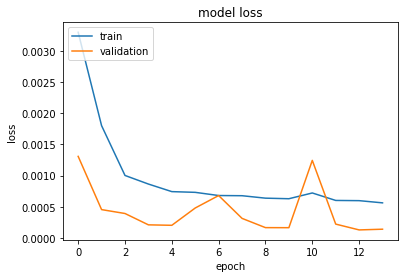

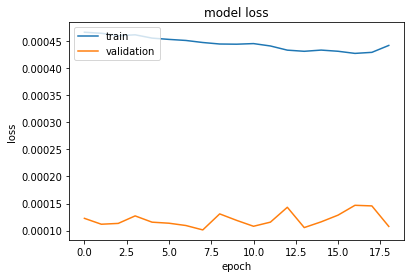

Validation set results
Region IDs : ['60_new', '60_end']
Forecast time range (h) : [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]
RMSE : [6, 17, 26, 35, 35, 51, 72, 116, 97, 94, 120, 127, 127, 125]
Average Taxi flows : [82, 85, 87, 81, 80, 97, 134, 203, 149, 180, 235, 214, 201, 189]
RMSE to average % : [7, 20, 29, 43, 43, 52, 53, 57, 65, 52, 51, 59, 63, 66]

Test set results
Forecast time range (h) : [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]
RMSE : [31, 31, 35, 38, 36, 35, 41, 53, 52, 74, 150, 139, 127, 131]
Average Taxi flows : [101, 120, 101, 91, 85, 84, 112, 143, 104, 118, 200, 170, 166, 167]
RMSE to average % : [30, 25, 34, 41, 42, 41, 36, 37, 50, 62, 75, 81, 76, 78]

time: 10min 3s


In [ ]:
regions_to_loop_flows = [["60_new", "60_end"]]

features_array = ["month", "weekday", "hour", "holiday"]


#MAY BE MODIFIED!!!!!!!
statistical_method = "LSTM_two_variate"
end_validation_index = convertDatetoHourIndex([10, 5, 8], 2016)
test_startDate = "2016-10-05 08:00"
test_start_date_title = "2016_10_05_800"
base_results_csv_path = "/content/gdrive/My Drive/urban-computing-project/LSTM_two_variate_results/"

base_results_csv_path = "/content/"

#setting training data
#forecastHourRange = 24*7*3
start_training_index = 0
end_training_index = end_validation_index - validation_range
end_testing_index = end_validation_index + test_range

#forecasts parameters
period_forecast_array_validation = [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 24*7, 24*7*2, 24*7*3]
period_forecast_array_test = [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]
period_forecast_array = [period_forecast_array_validation, period_forecast_array_test]

#lstm parameters
lstm_model_name = statistical_method
sequence_length = 6
batch_size = 64
n_weights = 420
number_epochs_array = [15, 20]
learning_rate_array = [0.01, 0.001]
verboseValue = 1

print("Testing on :", test_startDate)
print("Features :", features_array)
print()

for regionIDsarray in regions_to_loop_flows:

  print("Region IDs :", regionIDsarray)

  regionsIDstr = ""
  data_set = array([])
  for regionIDval in regionIDsarray:
    regionsIDstr = regionsIDstr + "_" + regionIDval
    y_dataset = array(taxitrips_df[regionIDval][start_training_index:end_testing_index].copy())
    y_dataset = y_dataset.reshape(y_dataset.shape[0], 1)

    if data_set.shape[0] == 0:
      data_set = y_dataset.copy()
    else:
      data_set = np.concatenate((data_set, y_dataset), axis=1)

  features_set = array([])
  for feature_title in features_array:
    feature_dataset = array(taxitrips_df[feature_title][start_training_index:end_testing_index].copy())
    feature_dataset = feature_dataset.reshape(feature_dataset.shape[0], 1)

    if features_set.shape[0] == 0:
      features_set = feature_dataset.copy()
    else:
      features_set = np.concatenate((features_set, feature_dataset), axis=1)


  results_CSV_FilePath = base_results_csv_path + lstm_model_name + regionsIDstr + "_" + test_start_date_title + ".csv"

  print("saving to", results_CSV_FilePath)

  runLSTMSimulationWithValidationMonitoring(results_CSV_FilePath, regionIDsarray, data_set, features_set, test_startDate, end_training_index, period_forecast_array, sequence_length, batch_size, n_weights, lstm_model_name, number_epochs_array, learning_rate_array, verboseValue)


**7 octobre:**

Validation set results

Region IDs : ['66_new', '66_end']

Forecast time range (h) : [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]

RMSE : [17, 33, 35, 31, 34, 78, 81, 130, 128, 135, 181, 159, 159, 168]

Average Taxi flows : [768, 826, 819, 830, 865, 925, 982, 952, 695, 760, 865, 723, 704, 686]

RMSE to average % : [2, 3, 4, 3, 3, 8, 8, 13, 18, 17, 20, 21, 22, 24]

[4, 3, 3, 3, 4, 4, 6, 12, 15, 16, 21, 36, 37, 39]

Test set results

Forecast time range (h) : [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]

RMSE : [44, 33, 36, 36, 41, 67, 91, 103, 125, 185, 179, 164, 154, 150]

Average Taxi flows : [868, 890, 878, 861, 878, 927, 1002, 982, 735, 771, 834, 675, 708, 716]

RMSE to average % : [5, 3, 4, 4, 4, 7, 9, 10, 17, 23, 21, 24, 21, 20]



Validation set results

Region IDs : ['66_new', '66_end']

Forecast time range (h) : [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336]

RMSE : [190, 235, 229, 198, 184, 203, 193, 171, 141, 141, 158, 126, 143]

Average Taxi flows : [1095, 1126, 1071, 1015, 1019, 1051, 1101, 1037, 755, 796, 859, 710, 674]

RMSE to average % : [17, 20, 21, 19, 18, 19, 17, 16, 18, 17, 18, 17, 21]

Test set results

Forecast time range (h) : [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]

RMSE : [125, 107, 103, 90, 92, 98, 126, 120, 123, 150, 169, 159, 176, 177]

Average Taxi flows : [868, 890, 878, 861, 878, 927, 1002, 982, 735, 771, 834, 675, 708, 716]

RMSE to average % : [14, 12, 11, 10, 10, 10, 12, 12, 16, 19, 20, 23, 24, 24]


**For 14 octobre**

Validation set results

Region IDs : ['66_new', '66_end']

Forecast time range (h) : [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336]

RMSE : [39, 107, 108, 112, 109, 101, 138, 161, 141, 181, 186, 194, 162]

Average Taxi flows : [780, 801, 780, 763, 783, 834, 890, 862, 626, 657, 696, 583, 615]

RMSE to average % : [5, 13, 13, 14, 13, 12, 15, 18, 22, 27, 26, 33, 26]

Test set results

Forecast time range (h) : [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]

RMSE : [43, 41, 53, 65, 58, 55, 75, 68, 64, 73, 105, 94, 96, 121]

Average Taxi flows : [805, 860, 820, 834, 856, 891, 975, 975, 714, 767, 838, 715, 712, 687]

RMSE to average % : [5, 4, 6, 7, 6, 6, 7, 6, 8, 9, 12, 13, 13, 17]

Validation set results

Region IDs : ['66_new', '66_end']

Forecasting : [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336]

RMSE : [25, 27, 38, 38, 55, 74, 91, 113, 98, 132, 130, 198, 178]

Average Taxi flows : [780, 801, 780, 763, 783, 834, 890, 862, 626, 657, 696, 583, 615]

RMSE to average % : [3, 3, 4, 4, 7, 8, 10, 13, 15, 20, 18, 33, 28]

Test set results

Forecasting : [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]

RMSE : [48, 76, 64, 93, 117, 100, 189, 170, 141, 154, 184, 179, 174, 178]

Average Taxi flows : [805, 860, 820, 834, 856, 891, 975, 975, 714, 767, 838, 715, 712, 687]

RMSE to average % : [5, 8, 7, 11, 13, 11, 19, 17, 19, 20, 21, 25, 24, 25]

26:

nweights : 420

batch : 64

epochs: 15, 10

RMSE : [5, 36, 36, 32, 33, 46, 42, 38, 34, 32, 29, 34, 35]

Average Taxi : [87, 83, 89, 103, 121, 165, 162, 150, 109, 112, 105, 98, 90]



In [ ]:
resultsdf = pd.read_csv("/content/LSTM_two_variate__26_new_26_end.csv")
resultsdf.head()

,Unnamed: 0,26_new_forecast,26_end_forecast,26_new_test,26_end_test,timestamp
0,0,125.312207,89.977704,126.0,77.0,2016-09-07 08:00:00
1,1,160.439267,101.281889,216.0,93.0,2016-09-07 09:00:00
2,2,175.858911,116.185771,207.0,84.0,2016-09-07 10:00:00
3,3,187.447994,136.100535,247.0,100.0,2016-09-07 11:00:00
4,4,194.948627,159.136458,197.0,84.0,2016-09-07 12:00:00


time: 30.6 ms


### **Testing 5 octobre 8AM**

In [ ]:
regions_to_loop_flows = regions_pairs_to_loop #[["66_new", "66_end"]]

features_array = ["month", "weekday", "hour", "holiday"]

#MAY BE MODIFIED!!!!!!!
statistical_method = "LSTM_two_var_MWHH"
end_validation_index = convertDatetoHourIndex([10, 5, 8], 2016)
test_startDate = "2016-10-05 08:00"
test_start_date_title = "2016_10_05_800"
base_results_csv_path = "/content/gdrive/My Drive/urban-computing-project/LSTM_two_variate_results/"

base_results_csv_path = "/content/"

#setting training data
#forecastHourRange = 24*7*3
start_training_index = 0
end_training_index = end_validation_index - validation_range
end_testing_index = end_validation_index + test_range

#forecasts parameters
period_forecast_array_validation = [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 24*7, 24*7*2]
period_forecast_array_test = [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]
period_forecast_array = [period_forecast_array_validation, period_forecast_array_test]

#lstm parameters
lstm_model_name = statistical_method
sequence_length = 6
batch_size = 64
n_weights = 450
number_epochs_array = [15, 10]
learning_rate_array = [0.01, 0.001]
verboseValue = 1

print("Testing on :", test_startDate)
print("Features :", features_array)
print()

for regionIDsarray in regions_to_loop_flows:

  print("Region IDs :", regionIDsarray)

  regionsIDstr = ""
  data_set = array([])
  for regionIDval in regionIDsarray:
    regionsIDstr = regionsIDstr + "_" + regionIDval
    y_dataset = array(taxitrips_df[regionIDval][start_training_index:end_testing_index].copy())
    y_dataset = y_dataset.reshape(y_dataset.shape[0], 1)

    if data_set.shape[0] == 0:
      data_set = y_dataset.copy()
    else:
      data_set = np.concatenate((data_set, y_dataset), axis=1)

  features_set = array([])
  for feature_title in features_array:
    feature_dataset = array(taxitrips_df[feature_title][start_training_index:end_testing_index].copy())
    feature_dataset = feature_dataset.reshape(feature_dataset.shape[0], 1)

    if features_set.shape[0] == 0:
      features_set = feature_dataset.copy()
    else:
      features_set = np.concatenate((features_set, feature_dataset), axis=1)


  results_CSV_FilePath = base_results_csv_path + lstm_model_name + regionsIDstr + "_" + test_start_date_title + ".csv"

  print("saving to", results_CSV_FilePath)

  runLSTMSimulation(results_CSV_FilePath, regionIDsarray, data_set, features_set, test_startDate, end_training_index, period_forecast_array, sequence_length, batch_size, n_weights, lstm_model_name, number_epochs_array, learning_rate_array, verboseValue)


Testing on : 2016-10-05 08:00
Features : ['month', 'weekday', 'hour', 'holiday']

Region IDs : ['66_new', '66_end']
saving to /content/LSTM_two_var_MWHH_66_new_66_end_2016_10_05_800.csv
Epoch 1/14
236/236 [==============================] - 19s 80ms/step - loss: 53.6746
Epoch 2/14
236/236 [==============================] - 19s 80ms/step - loss: 0.0036
Epoch 3/14
236/236 [==============================] - 19s 81ms/step - loss: 0.0023
Epoch 4/14
236/236 [==============================] - 19s 79ms/step - loss: 0.0020
Epoch 5/14
236/236 [==============================] - 19s 79ms/step - loss: 0.0020
Epoch 6/14
236/236 [==============================] - 19s 80ms/step - loss: 0.0018
Epoch 7/14
236/236 [==============================] - 19s 80ms/step - loss: 0.0016
Epoch 8/14
236/236 [==============================] - 19s 80ms/step - loss: 0.0018
Epoch 9/14
236/236 [==============================] - 19s 81ms/step - loss: 0.0015
Epoch 10/14
236/236 [==============================] - 19s 80ms/st

66:

batch 65 
nweights 470
epochs 10 10

RMSE: [161, 183, 178, 154, 145, 135, 127, 132, 109, 115, 129, 110, 144]

RMSE (other wiht 465 17 10): [109, 100, 97, 94, 85, 93, 88, 112, 98, 121, 139, 135, 158]

Average Taxi flows : [1095, 1126, 1071, 1015, 1019, 1051, 1101, 1037, 755, 796, 859, 710, 674]

In [ ]:
resultsdf = pd.read_csv("/content/LSTM_two_variate__66_new_66_end.csv")
resultsdf.head()

,Unnamed: 0,66_new_forecast,66_end_forecast,66_new_test,66_end_test,timestamp
0,0,998.559728,560.217304,1141.0,595.0,2016-10-05 08:00:00
1,1,992.678063,696.645304,1103.0,724.0,2016-10-05 09:00:00
2,2,797.702052,676.854485,907.0,803.0,2016-10-05 10:00:00
3,3,763.601174,758.709401,797.0,825.0,2016-10-05 11:00:00
4,4,842.067610,888.988940,871.0,1022.0,2016-10-05 12:00:00


time: 25 ms


In [ ]:
resultsdf = pd.read_csv("/content/LSTM_two_variate_66_new66_end.csv")
resultsdf.head()

,Unnamed: 0,66_new_forecast,66_end_forecast,66_new_test,66_end_test,timestamp
0,0,1010.937213,541.247729,1141.0,595.0,2016-10-05 08:00:00
1,1,1039.500943,695.708975,1103.0,724.0,2016-10-05 09:00:00
2,2,849.303351,689.876416,907.0,803.0,2016-10-05 10:00:00
3,3,784.445345,752.201009,797.0,825.0,2016-10-05 11:00:00
4,4,885.360155,909.178052,871.0,1022.0,2016-10-05 12:00:00


time: 40.7 ms


In [ ]:
results_df_66_end = pd.read_csv("/content/gdrive/My Drive/urban-computing-project/TBATS_results/TBATS_66_end_2016_10_05_800.csv")
results_df_66_new = pd.read_csv("/content/gdrive/My Drive/urban-computing-project/TBATS_results/TBATS_66_new_2016_10_05_800.csv")

results_df_66_end.head()

all_results_df = pd.DataFrame()

all_results_df["timestamp"] = resultsdf["timestamp"].copy()
all_results_df["y_new_LSTM_forecast"] = resultsdf["66_new_forecast"].copy()
all_results_df["y_new"] = resultsdf["66_new_test"].copy()
all_results_df["y_new_TBATS_forecast"] = results_df_66_new["yforecast"].copy()
all_results_df["y_end_LSTM_forecast"] = resultsdf["66_end_forecast"].copy()
all_results_df["y_end"] = resultsdf["66_end_test"].copy()
all_results_df["y_end_TBATS_forecast"] = results_df_66_end["yforecast"].copy()
all_results_df.head()

,timestamp,y_new_LSTM_forecast,y_new,y_new_TBATS_forecast,y_end_LSTM_forecast,y_end,y_end_TBATS_forecast
0,2016-10-05 08:00:00,1010.937213,1141.0,936.009549,541.247729,595.0,533.711667
1,2016-10-05 09:00:00,1039.500943,1103.0,991.403120,695.708975,724.0,685.033680
2,2016-10-05 10:00:00,849.303351,907.0,854.976458,689.876416,803.0,714.773246
3,2016-10-05 11:00:00,784.445345,797.0,810.130331,752.201009,825.0,778.292041
4,2016-10-05 12:00:00,885.360155,871.0,856.986224,909.178052,1022.0,922.485750


time: 41.6 ms


In [ ]:
results_df_66_end.head()

,Unnamed: 0,timestamp,regionID_flow,ytest,yforecast
0,0,2016-10-05 08:00:00,66_end,595,533.711667
1,1,2016-10-05 09:00:00,66_end,724,685.033680
2,2,2016-10-05 10:00:00,66_end,803,714.773246
3,3,2016-10-05 11:00:00,66_end,825,778.292041
4,4,2016-10-05 12:00:00,66_end,1022,922.485750


time: 19.7 ms


### **All multivariate series LSTM**

In [ ]:
all_regions_together_to_loop = []

p = 0
while p < len(regions_to_loop_newflow):
  all_regions_together_to_loop.append(regions_to_loop_newflow[p])
  all_regions_together_to_loop.append(regions_to_loop_endflow[p])
  p = p + 1

print(all_regions_together_to_loop)

['26_new', '26_end', '53_new', '53_end', '60_new', '60_end', '62_new', '62_end', '66_new', '66_end', '68_new', '68_end', '72_new', '72_end', '73_new', '73_end', '75_new', '75_end', '76_new', '76_end', '77_new', '77_end', '78_new', '78_end', '82_new', '82_end', '83_new', '83_end', '88_new', '88_end', '125_new', '125_end']
time: 2.39 ms


Testing on : 2016-10-05 08:00
Features : ['month', 'weekday', 'hour', 'holiday']

Region IDs : ALL REGION IDs
saving to /content/LSTM_multivar_downtown__2016_10_05_800.csv

startValidationIndex, startTestIndex 14096 15440

Model training information
Initial training date : 2015-01-01 00:00:00
End training date : 2016-08-10 07:00:00
Start Validation date : 2016-08-10 08:00:00
End validation date : 2016-10-05 02:00:00
Start test date : 2016-10-05 08:00:00
End test date : 2016-10-26 07:00:00
Start test input date : 2016-10-05 02:00:00
Sequence length : 6

First round of training [epochs, learning rate] 70 0.01

Epoch 1/70
111/111 [==============================] - 18s 160ms/step - loss: 27498019.1833 - val_loss: 0.0072
Epoch 2/70
111/111 [==============================] - 17s 157ms/step - loss: 0.0087 - val_loss: 0.0069
Epoch 3/70
111/111 [==============================] - 17s 157ms/step - loss: 0.0058 - val_loss: 0.0051
Epoch 4/70
111/111 [==============================] - 17s 157ms/step

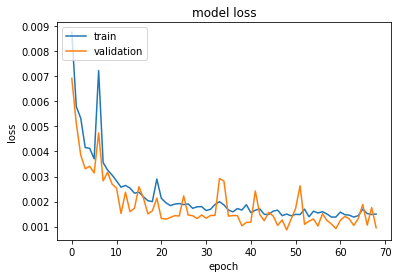

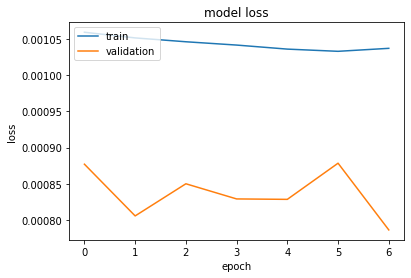

Validation set results
Region IDs : ['66_new', '66_end', '72_new', '72_end', '76_new', '76_end', '77_new', '77_end', '78_new', '78_end', '83_new', '83_end']
Forecast time range (h) : [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]
RMSE : [31, 39, 36, 38, 42, 52, 50, 49, 42, 68, 103, 111, 101, 99]
Average Taxi flows : [413, 438, 432, 433, 443, 465, 472, 430, 310, 334, 353, 290, 282, 276]
RMSE to average % : [7, 8, 8, 8, 9, 11, 10, 11, 13, 20, 29, 38, 35, 35]

Test set results
Forecast time range (h) : [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]
RMSE : [56, 63, 73, 71, 68, 67, 70, 65, 72, 108, 108, 98, 112, 116]
Average Taxi flows : [457, 483, 480, 471, 474, 478, 493, 449, 332, 343, 348, 277, 296, 298]
RMSE to average % : [12, 13, 15, 15, 14, 14, 14, 14, 21, 31, 31, 35, 37, 38]

time: 23min 43s


In [ ]:
#regions_to_loop_flows = [all_regions_together_to_loop]
regions_to_loop_flows = [['66_new', '66_end', '72_new', '72_end', '76_new', '76_end', '77_new', '77_end', '78_new', '78_end',  '83_new', '83_end']]

features_array = ["month", "weekday", "hour", "holiday"]

#MAY BE MODIFIED!!!!!!!
statistical_method = "LSTM_multivar_"
end_validation_index = convertDatetoHourIndex([10, 5, 8], 2016)
test_startDate = "2016-10-05 08:00"
test_start_date_title = "2016_10_05_800"
base_results_csv_path = "/content/gdrive/My Drive/urban-computing-project/LSTM_multivariate_results/"

base_results_csv_path = "/content/"

#setting training data
#forecastHourRange = 24*7*3
start_training_index = 0
end_training_index = end_validation_index - validation_range
end_testing_index = end_validation_index + test_range

#forecasts parameters
period_forecast_array_validation = [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 24*7, 24*7*2, 24*7*3]
period_forecast_array_test = [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]
period_forecast_array = [period_forecast_array_validation, period_forecast_array_test]

#lstm parameters
lstm_model_name = statistical_method
sequence_length = 6
batch_size = 128
n_weights = 2850
number_epochs_array = [70, 8]
learning_rate_array = [0.01, 0.001]
verboseValue = 1

print("Testing on :", test_startDate)
print("Features :", features_array)
print()

for regionIDsarray in regions_to_loop_flows:

  print("Region IDs : ALL REGION IDs")

  regionsIDstr = "downtown_"
  data_set = array([])
  for regionIDval in regionIDsarray:
    #regionsIDstr = regionsIDstr + "_" + regionIDval
    y_dataset = array(taxitrips_df[regionIDval][start_training_index:end_testing_index].copy())
    y_dataset = y_dataset.reshape(y_dataset.shape[0], 1)

    if data_set.shape[0] == 0:
      data_set = y_dataset.copy()
    else:
      data_set = np.concatenate((data_set, y_dataset), axis=1)

  features_set = array([])
  for feature_title in features_array:
    feature_dataset = array(taxitrips_df[feature_title][start_training_index:end_testing_index].copy())
    feature_dataset = feature_dataset.reshape(feature_dataset.shape[0], 1)

    if features_set.shape[0] == 0:
      features_set = feature_dataset.copy()
    else:
      features_set = np.concatenate((features_set, feature_dataset), axis=1)


  results_CSV_FilePath = base_results_csv_path + lstm_model_name + regionsIDstr + "_" + test_start_date_title + ".csv"

  print("saving to", results_CSV_FilePath)
  
  print()

  runLSTMSimulationWithValidationMonitoring(results_CSV_FilePath, regionIDsarray, data_set, features_set, test_startDate, end_training_index, period_forecast_array, sequence_length, batch_size, n_weights, lstm_model_name, number_epochs_array, learning_rate_array, verboseValue)


Testing on : 2016-10-05 08:00
Features : ['month', 'weekday', 'hour', 'holiday']

Region IDs : ALL REGION IDs
saving to /content/LSTM_multivar_downtown__2016_10_05_800.csv

startValidationIndex, startTestIndex 14096 15440

Model training information
Initial training date : 2015-01-01 00:00:00
End training date : 2016-08-10 07:00:00
Start Validation date : 2016-08-10 08:00:00
End validation date : 2016-10-05 02:00:00
Start test date : 2016-10-05 08:00:00
End test date : 2016-10-26 07:00:00
Start test input date : 2016-10-05 02:00:00
Sequence length : 6

First round of training [epochs, learning rate] 63 0.01

Epoch 1/63
111/111 [==============================] - 20s 176ms/step - loss: 1643906.6148 - val_loss: 0.0076
Epoch 2/63
111/111 [==============================] - 19s 172ms/step - loss: 0.0064 - val_loss: 0.0042
Epoch 3/63
111/111 [==============================] - 19s 172ms/step - loss: 0.0052 - val_loss: 0.0035
Epoch 4/63
111/111 [==============================] - 19s 171ms/step 

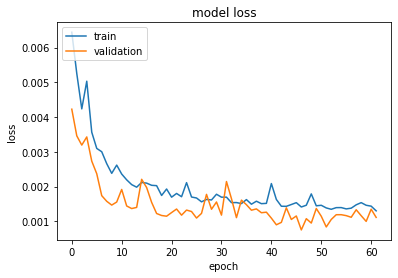

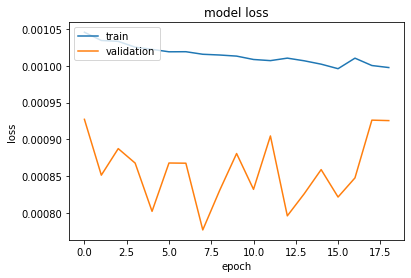

Validation set results
Region IDs : ['66_new', '66_end', '72_new', '72_end', '76_new', '76_end', '77_new', '77_end', '78_new', '78_end', '83_new', '83_end']
Forecast time range (h) : [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]
RMSE : [26, 42, 39, 37, 38, 53, 55, 61, 61, 91, 121, 103, 94, 95]
Average Taxi flows : [413, 438, 432, 433, 443, 465, 472, 430, 310, 334, 353, 290, 282, 276]
RMSE to average % : [6, 9, 9, 8, 8, 11, 11, 14, 19, 27, 34, 35, 33, 34]

Test set results
Forecast time range (h) : [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]
RMSE : [42, 59, 64, 62, 60, 68, 76, 76, 87, 128, 129, 146, 145, 143]
Average Taxi flows : [457, 483, 480, 471, 474, 478, 493, 449, 332, 343, 348, 277, 296, 298]
RMSE to average % : [9, 12, 13, 13, 12, 14, 15, 16, 26, 37, 37, 52, 48, 47]

time: 27min 19s


In [ ]:
#regions_to_loop_flows = [all_regions_together_to_loop]
regions_to_loop_flows = [['66_new', '66_end', '72_new', '72_end', '76_new', '76_end', '77_new', '77_end', '78_new', '78_end',  '83_new', '83_end']]

features_array = ["month", "weekday", "hour", "holiday"]

#MAY BE MODIFIED!!!!!!!
statistical_method = "LSTM_multivar_"
end_validation_index = convertDatetoHourIndex([10, 5, 8], 2016)
test_startDate = "2016-10-05 08:00"
test_start_date_title = "2016_10_05_800"
base_results_csv_path = "/content/gdrive/My Drive/urban-computing-project/LSTM_multivariate_results/"

base_results_csv_path = "/content/"

#setting training data
#forecastHourRange = 24*7*3
start_training_index = 0
end_training_index = end_validation_index - validation_range
end_testing_index = end_validation_index + test_range

#forecasts parameters
period_forecast_array_validation = [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 24*7, 24*7*2, 24*7*3]
period_forecast_array_test = [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]
period_forecast_array = [period_forecast_array_validation, period_forecast_array_test]

#lstm parameters
lstm_model_name = statistical_method
sequence_length = 6
batch_size = 128
n_weights = 3000
number_epochs_array = [63, 20]
learning_rate_array = [0.01, 0.001]
verboseValue = 1

print("Testing on :", test_startDate)
print("Features :", features_array)
print()

for regionIDsarray in regions_to_loop_flows:

  print("Region IDs : ALL REGION IDs")

  regionsIDstr = "downtown_"
  data_set = array([])
  for regionIDval in regionIDsarray:
    #regionsIDstr = regionsIDstr + "_" + regionIDval
    y_dataset = array(taxitrips_df[regionIDval][start_training_index:end_testing_index].copy())
    y_dataset = y_dataset.reshape(y_dataset.shape[0], 1)

    if data_set.shape[0] == 0:
      data_set = y_dataset.copy()
    else:
      data_set = np.concatenate((data_set, y_dataset), axis=1)

  features_set = array([])
  for feature_title in features_array:
    feature_dataset = array(taxitrips_df[feature_title][start_training_index:end_testing_index].copy())
    feature_dataset = feature_dataset.reshape(feature_dataset.shape[0], 1)

    if features_set.shape[0] == 0:
      features_set = feature_dataset.copy()
    else:
      features_set = np.concatenate((features_set, feature_dataset), axis=1)


  results_CSV_FilePath = base_results_csv_path + lstm_model_name + regionsIDstr + "_" + test_start_date_title + ".csv"

  print("saving to", results_CSV_FilePath)
  
  print()

  runLSTMSimulationWithValidationMonitoring(results_CSV_FilePath, regionIDsarray, data_set, features_set, test_startDate, end_training_index, period_forecast_array, sequence_length, batch_size, n_weights, lstm_model_name, number_epochs_array, learning_rate_array, verboseValue)


2700 66, 8 epochs 20 min


In [ ]:
results_df = pd.read_csv("/content/LSTM_multivar_cluster_1__2016_12_07_800.csv")
all_results_df = pd.DataFrame()
all_results_df["y_new"] = results_df["66_new_test"].copy()
all_results_df["y_new_LSTM"] = results_df["66_new_forecast"].copy()
all_results_df["timestamp"] = results_df["timestamp"].copy()
all_results_df["y_end"] = results_df["66_end_test"].copy()
all_results_df["y_end_LSTM"] = results_df["66_end_forecast"].copy()
all_results_df.head()

,y_new,y_new_LSTM_forecast,timestamp,y_end,y_end_LSTM_forecast
0,1107.0,1036.359508,2016-09-07 08:00:00,571.0,563.928743
1,1140.0,1160.605078,2016-09-07 09:00:00,845.0,699.581582
2,812.0,939.376062,2016-09-07 10:00:00,770.0,745.892042
3,790.0,799.815823,2016-09-07 11:00:00,819.0,834.804514
4,860.0,883.725192,2016-09-07 12:00:00,953.0,937.126775


time: 36.2 ms


In [ ]:
all_results_df.tail()

,y_new,y_new_LSTM_forecast,timestamp,y_end,y_end_LSTM_forecast
499,39.0,70.740582,2016-09-28 03:00:00,18.0,24.047345
500,36.0,52.874090,2016-09-28 04:00:00,9.0,19.423645
501,85.0,50.055948,2016-09-28 05:00:00,16.0,0.000000
502,250.0,218.734034,2016-09-28 06:00:00,79.0,46.896813
503,820.0,521.487867,2016-09-28 07:00:00,363.0,250.276194


time: 21.5 ms


### **Airport region**

Testing on : 2016-10-05 08:00
Features : ['month', 'weekday', 'hour', 'holiday']

Region IDs : ALL REGION IDs
saving to /content/LSTM_multivar_all_regions_2016_10_05_800.csv

startValidationIndex, startTestIndex 14096 15440

Model training information
Initial training date : 2015-01-01 00:00:00
End training date : 2016-08-10 07:00:00
Start Validation date : 2016-08-10 08:00:00
End validation date : 2016-10-05 02:00:00
Start test date : 2016-10-05 08:00:00
End test date : 2016-10-26 07:00:00
Start test input date : 2016-10-05 02:00:00
Sequence length : 6

First round of training [epochs, learning rate] 70 0.01

Epoch 1/70
56/56 [==============================] - 3s 55ms/step - loss: 4129.0854 - val_loss: 0.0268
Epoch 2/70
56/56 [==============================] - 3s 47ms/step - loss: 0.0138 - val_loss: 0.0185
Epoch 3/70
56/56 [==============================] - 3s 48ms/step - loss: 0.0097 - val_loss: 0.0160
Epoch 4/70
56/56 [==============================] - 3s 46ms/step - loss: 0.0075 - 

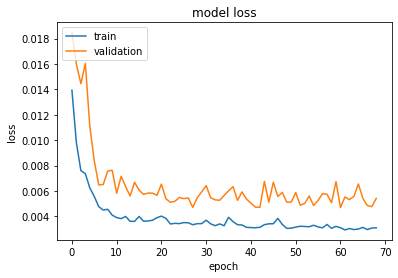

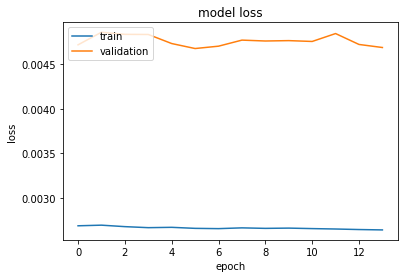

Validation set results
Region IDs : ['26_new', '26_end', '125_new', '125_end']
Forecast time range (h) : [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]
RMSE : [9, 15, 18, 17, 17, 18, 18, 16, 14, 15, 20, 29, 28, 29]
Average Taxi flows : [71, 82, 93, 98, 103, 119, 118, 106, 79, 82, 79, 70, 70, 69]
RMSE to average % : [12, 18, 19, 17, 16, 15, 15, 15, 17, 18, 25, 41, 40, 42]

Test set results
Forecast time range (h) : [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]
RMSE : [21, 32, 27, 27, 29, 33, 35, 34, 28, 35, 36, 32, 40, 41]
Average Taxi flows : [91, 103, 106, 112, 121, 140, 139, 125, 91, 97, 95, 78, 83, 85]
RMSE to average % : [23, 31, 25, 24, 23, 23, 25, 27, 30, 36, 37, 41, 48, 48]

time: 3min 52s


In [ ]:
#regions_to_loop_flows = [all_regions_together_to_loop]
regions_to_loop_flows = [['26_new', '26_end','125_new', '125_end']]

features_array = ["month", "weekday", "hour", "holiday"]

#MAY BE MODIFIED!!!!!!!
statistical_method = "LSTM_multivar_"
end_validation_index = convertDatetoHourIndex([10, 5, 8], 2016)
test_startDate = "2016-10-05 08:00"
test_start_date_title = "2016_10_05_800"
base_results_csv_path = "/content/gdrive/My Drive/urban-computing-project/LSTM_multivariate_results/"

base_results_csv_path = "/content/"

#setting training data
#forecastHourRange = 24*7*3
start_training_index = 0
end_training_index = end_validation_index - validation_range
end_testing_index = end_validation_index + test_range

#forecasts parameters
period_forecast_array_validation = [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 24*7, 24*7*2, 24*7*3]
period_forecast_array_test = [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]
period_forecast_array = [period_forecast_array_validation, period_forecast_array_test]

#lstm parameters
lstm_model_name = statistical_method
sequence_length = 6
batch_size = 256
n_weights = 1000
number_epochs_array = [70, 15]
learning_rate_array = [0.01, 0.001]
verboseValue = 1

print("Testing on :", test_startDate)
print("Features :", features_array)
print()

for regionIDsarray in regions_to_loop_flows:

  print("Region IDs : ALL REGION IDs")

  regionsIDstr = "26_125_"
  data_set = array([])
  for regionIDval in regionIDsarray:
    #regionsIDstr = regionsIDstr + "_" + regionIDval
    y_dataset = array(taxitrips_df[regionIDval][start_training_index:end_testing_index].copy())
    y_dataset = y_dataset.reshape(y_dataset.shape[0], 1)

    if data_set.shape[0] == 0:
      data_set = y_dataset.copy()
    else:
      data_set = np.concatenate((data_set, y_dataset), axis=1)

  features_set = array([])
  for feature_title in features_array:
    feature_dataset = array(taxitrips_df[feature_title][start_training_index:end_testing_index].copy())
    feature_dataset = feature_dataset.reshape(feature_dataset.shape[0], 1)

    if features_set.shape[0] == 0:
      features_set = feature_dataset.copy()
    else:
      features_set = np.concatenate((features_set, feature_dataset), axis=1)


  results_CSV_FilePath = base_results_csv_path + lstm_model_name + regionsIDstr + "_" + test_start_date_title + ".csv"

  print("saving to", results_CSV_FilePath)
  
  print()

  runLSTMSimulationWithValidationMonitoring(results_CSV_FilePath, regionIDsarray, data_set, features_set, test_startDate, end_training_index, period_forecast_array, sequence_length, batch_size, n_weights, lstm_model_name, number_epochs_array, learning_rate_array, verboseValue)


### **Regions 88 and 82**

Testing on : 2016-10-05 08:00
Features : ['month', 'weekday', 'hour', 'holiday']

Region IDs : ALL REGION IDs
saving to /content/LSTM_multivar_82_88__2016_10_05_800.csv

startValidationIndex, startTestIndex 14096 15440

Model training information
Initial training date : 2015-01-01 00:00:00
End training date : 2016-08-10 07:00:00
Start Validation date : 2016-08-10 08:00:00
End validation date : 2016-10-05 02:00:00
Start test date : 2016-10-05 08:00:00
End test date : 2016-10-26 07:00:00
Start test input date : 2016-10-05 02:00:00
Sequence length : 6

First round of training [epochs, learning rate] 100 0.01

Epoch 1/100
56/56 [==============================] - 3s 55ms/step - loss: 1457.0537 - val_loss: 0.0201
Epoch 2/100
56/56 [==============================] - 3s 46ms/step - loss: 0.0160 - val_loss: 0.0130
Epoch 3/100
56/56 [==============================] - 3s 48ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 4/100
56/56 [==============================] - 3s 45ms/step - loss: 0.0072 - 

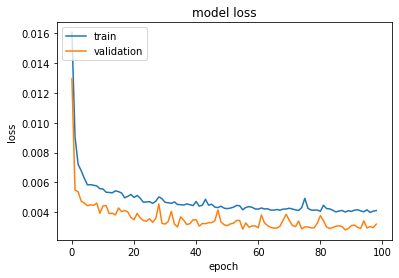

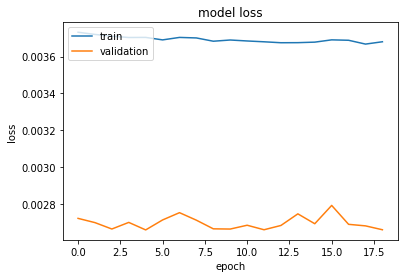

Validation set results
Region IDs : ['82_new', '82_end', '88_new', '88_end']
Forecast time range (h) : [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]
RMSE : [6, 6, 6, 5, 6, 6, 6, 5, 4, 7, 8, 7, 6, 6]
Average Taxi flows : [22, 23, 24, 23, 25, 26, 28, 27, 19, 22, 24, 19, 19, 19]
RMSE to average % : [27, 26, 25, 21, 24, 23, 21, 18, 21, 31, 33, 36, 31, 31]

Test set results
Forecast time range (h) : [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]
RMSE : [3, 7, 6, 7, 7, 9, 9, 9, 8, 9, 9, 10, 9, 9]
Average Taxi flows : [26, 31, 30, 31, 31, 31, 33, 32, 23, 24, 26, 20, 21, 21]
RMSE to average % : [11, 22, 20, 22, 22, 29, 27, 28, 34, 37, 34, 50, 42, 42]

time: 5min 24s


In [ ]:
#regions_to_loop_flows = [all_regions_together_to_loop]
regions_to_loop_flows = [['82_new', '82_end','88_new', '88_end']]

features_array = ["month", "weekday", "hour", "holiday"]

#MAY BE MODIFIED!!!!!!!
statistical_method = "LSTM_multivar_"
end_validation_index = convertDatetoHourIndex([10, 5, 8], 2016)
test_startDate = "2016-10-05 08:00"
test_start_date_title = "2016_10_05_800"
base_results_csv_path = "/content/gdrive/My Drive/urban-computing-project/LSTM_multivariate_results/"

base_results_csv_path = "/content/"

#setting training data
#forecastHourRange = 24*7*3
start_training_index = 0
end_training_index = end_validation_index - validation_range
end_testing_index = end_validation_index + test_range

#forecasts parameters
period_forecast_array_validation = [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 24*7, 24*7*2, 24*7*3]
period_forecast_array_test = [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]
period_forecast_array = [period_forecast_array_validation, period_forecast_array_test]

#lstm parameters
lstm_model_name = statistical_method
sequence_length = 6
batch_size = 256
n_weights = 1000
number_epochs_array = [120, 20]
learning_rate_array = [0.02, 0.001]
verboseValue = 1

print("Testing on :", test_startDate)
print("Features :", features_array)
print()

for regionIDsarray in regions_to_loop_flows:

  print("Region IDs : ALL REGION IDs")

  regionsIDstr = "82_88_"
  data_set = array([])
  for regionIDval in regionIDsarray:
    #regionsIDstr = regionsIDstr + "_" + regionIDval
    y_dataset = array(taxitrips_df[regionIDval][start_training_index:end_testing_index].copy())
    y_dataset = y_dataset.reshape(y_dataset.shape[0], 1)

    if data_set.shape[0] == 0:
      data_set = y_dataset.copy()
    else:
      data_set = np.concatenate((data_set, y_dataset), axis=1)

  features_set = array([])
  for feature_title in features_array:
    feature_dataset = array(taxitrips_df[feature_title][start_training_index:end_testing_index].copy())
    feature_dataset = feature_dataset.reshape(feature_dataset.shape[0], 1)

    if features_set.shape[0] == 0:
      features_set = feature_dataset.copy()
    else:
      features_set = np.concatenate((features_set, feature_dataset), axis=1)


  results_CSV_FilePath = base_results_csv_path + lstm_model_name + regionsIDstr + "_" + test_start_date_title + ".csv"

  print("saving to", results_CSV_FilePath)
  
  print()

  runLSTMSimulationWithValidationMonitoring(results_CSV_FilePath, regionIDsarray, data_set, features_set, test_startDate, end_training_index, period_forecast_array, sequence_length, batch_size, n_weights, lstm_model_name, number_epochs_array, learning_rate_array, verboseValue)


# **Building Demo Model**

**This code includes saving the model**

Testing on : 2016-03-01 08:00
Features : ['month', 'weekday', 'hour', 'holiday']

Region IDs : ALL REGION IDs
saving to /content/LSTM_multivar_downtown__2016_03_01_800.csv

startValidationIndex, startTestIndex 8864 10208

Model training information
Initial training date : 2015-01-01 00:00:00
End training date : 2016-01-05 07:00:00
Start Validation date : 2016-01-05 08:00:00
End validation date : 2016-03-01 02:00:00
Start test date : 2016-03-01 08:00:00
End test date : 2016-03-22 07:00:00
Start test input date : 2016-03-01 02:00:00
Sequence length : 6

First round of training [epochs, learning rate] 100 0.01

Epoch 1/100
35/35 [==============================] - 5s 136ms/step - loss: 147800162.5371 - val_loss: 0.0375
Epoch 2/100
35/35 [==============================] - 4s 125ms/step - loss: 0.0234 - val_loss: 0.0178
Epoch 3/100
35/35 [==============================] - 4s 126ms/step - loss: 0.0159 - val_loss: 0.0107
Epoch 4/100
35/35 [==============================] - 4s 126ms/step - loss

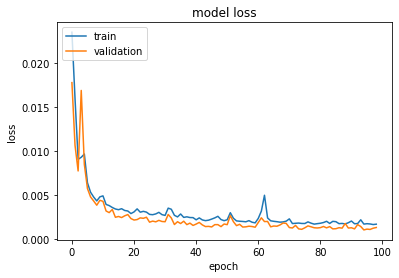

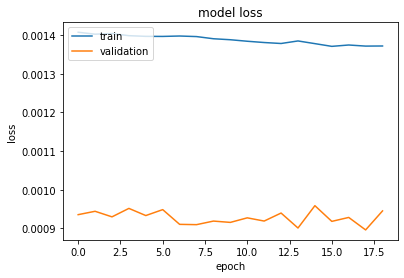

Validation set results
Region IDs : ['66_new', '66_end', '72_new', '72_end', '76_new', '76_end', '77_new', '77_end', '78_new', '78_end', '83_new', '83_end']
Forecast time range (h) : [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]
RMSE : [39, 61, 66, 65, 70, 69, 87, 85, 70, 72, 86, 91, 86, 86]
Average Taxi flows : [352, 387, 372, 353, 343, 342, 351, 308, 217, 228, 238, 229, 242, 247]
RMSE to average % : [11, 15, 17, 18, 20, 20, 24, 27, 32, 31, 36, 39, 35, 34]

Test set results
Forecast time range (h) : [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]
RMSE : [19, 37, 39, 38, 37, 52, 65, 60, 50, 50, 59, 73, 105, 95]
Average Taxi flows : [426, 458, 444, 431, 432, 445, 465, 417, 296, 301, 313, 287, 292, 291]
RMSE to average % : [4, 8, 8, 8, 8, 11, 13, 14, 16, 16, 18, 25, 35, 32]

time: 10min 20s


In [ ]:
#regions_to_loop_flows = [all_regions_together_to_loop]
regions_to_loop_flows = [['66_new', '66_end', '72_new', '72_end', '76_new', '76_end', '77_new', '77_end', '78_new', '78_end',  '83_new', '83_end']]

features_array = ["month", "weekday", "hour", "holiday"]

#MAY BE MODIFIED!!!!!!!
statistical_method = "LSTM_multivar_"
end_validation_index = convertDatetoHourIndex([3, 1, 8], 2016)
test_startDate = "2016-03-01 08:00"
test_start_date_title = "2016_03_01_800"
base_results_csv_path = "/content/gdrive/My Drive/urban-computing-project/LSTM_multivariate_results/"

base_results_csv_path = "/content/"

save_model_to_path = base_results_csv_path + statistical_method + "downtown"


#setting training data
#forecastHourRange = 24*7*3
start_training_index = 0
end_training_index = end_validation_index - validation_range
end_testing_index = end_validation_index + test_range

#forecasts parameters
period_forecast_array_validation = [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 24*7, 24*7*2, 24*7*3]
period_forecast_array_test = [1, 2, 3, 4, 5, 10, 12, 16, 24, 48, 72, 168, 336, 504]
period_forecast_array = [period_forecast_array_validation, period_forecast_array_test]

#lstm parameters
lstm_model_name = statistical_method
sequence_length = 6
batch_size = 256
n_weights = 3050
number_epochs_array = [100, 20]
learning_rate_array = [0.01, 0.001]
verboseValue = 1

print("Testing on :", test_startDate)
print("Features :", features_array)
print()

for regionIDsarray in regions_to_loop_flows:

  print("Region IDs : ALL REGION IDs")

  regionsIDstr = "downtown_"
  data_set = array([])
  for regionIDval in regionIDsarray:
    #regionsIDstr = regionsIDstr + "_" + regionIDval
    y_dataset = array(taxitrips_df[regionIDval][start_training_index:end_testing_index].copy())
    y_dataset = y_dataset.reshape(y_dataset.shape[0], 1)

    if data_set.shape[0] == 0:
      data_set = y_dataset.copy()
    else:
      data_set = np.concatenate((data_set, y_dataset), axis=1)

  features_set = array([])
  for feature_title in features_array:
    feature_dataset = array(taxitrips_df[feature_title][start_training_index:end_testing_index].copy())
    feature_dataset = feature_dataset.reshape(feature_dataset.shape[0], 1)

    if features_set.shape[0] == 0:
      features_set = feature_dataset.copy()
    else:
      features_set = np.concatenate((features_set, feature_dataset), axis=1)


  results_CSV_FilePath = base_results_csv_path + lstm_model_name + regionsIDstr + "_" + test_start_date_title + ".csv"

  print("saving to", results_CSV_FilePath)
  
  print()

  runLSTMSimulationWithValidationMonitoring(results_CSV_FilePath, regionIDsarray, data_set, features_set, test_startDate, end_training_index, period_forecast_array, sequence_length, batch_size, n_weights, lstm_model_name, number_epochs_array, learning_rate_array, verboseValue, save_model_to_path)


# **Testing Saved Model**

In [ ]:
model_full_path = "/content/gdrive/My Drive/urban-computing-project/lstm_model_based_on_2105/LSTM_multivar_downtown"

lstmModel = returnLSTMModelSaved(model_full_path)

NameError: ignored

In [ ]:
#saving the file into directory 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
